/tmp/ipykernel_13/2480380676.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(self.path + file) # load data


Plotting and saving for class: DJI
Plot saved as: ./plots/DJI_combined_plot.png


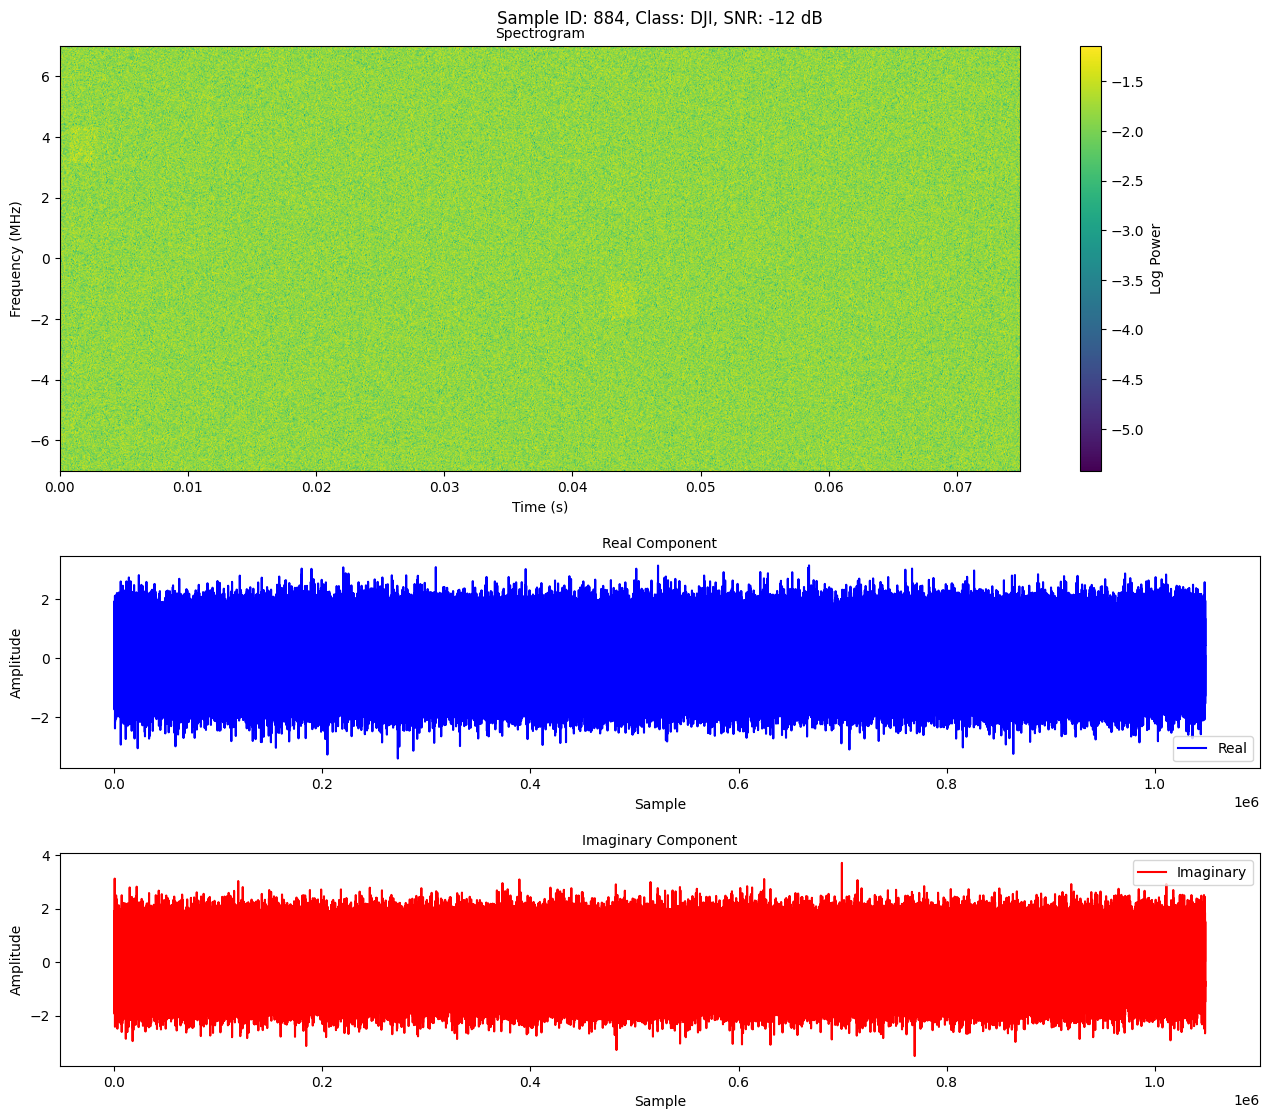

Completed plotting and saving for DJI

Plotting and saving for class: FutabaT14
Plot saved as: ./plots/FutabaT14_combined_plot.png


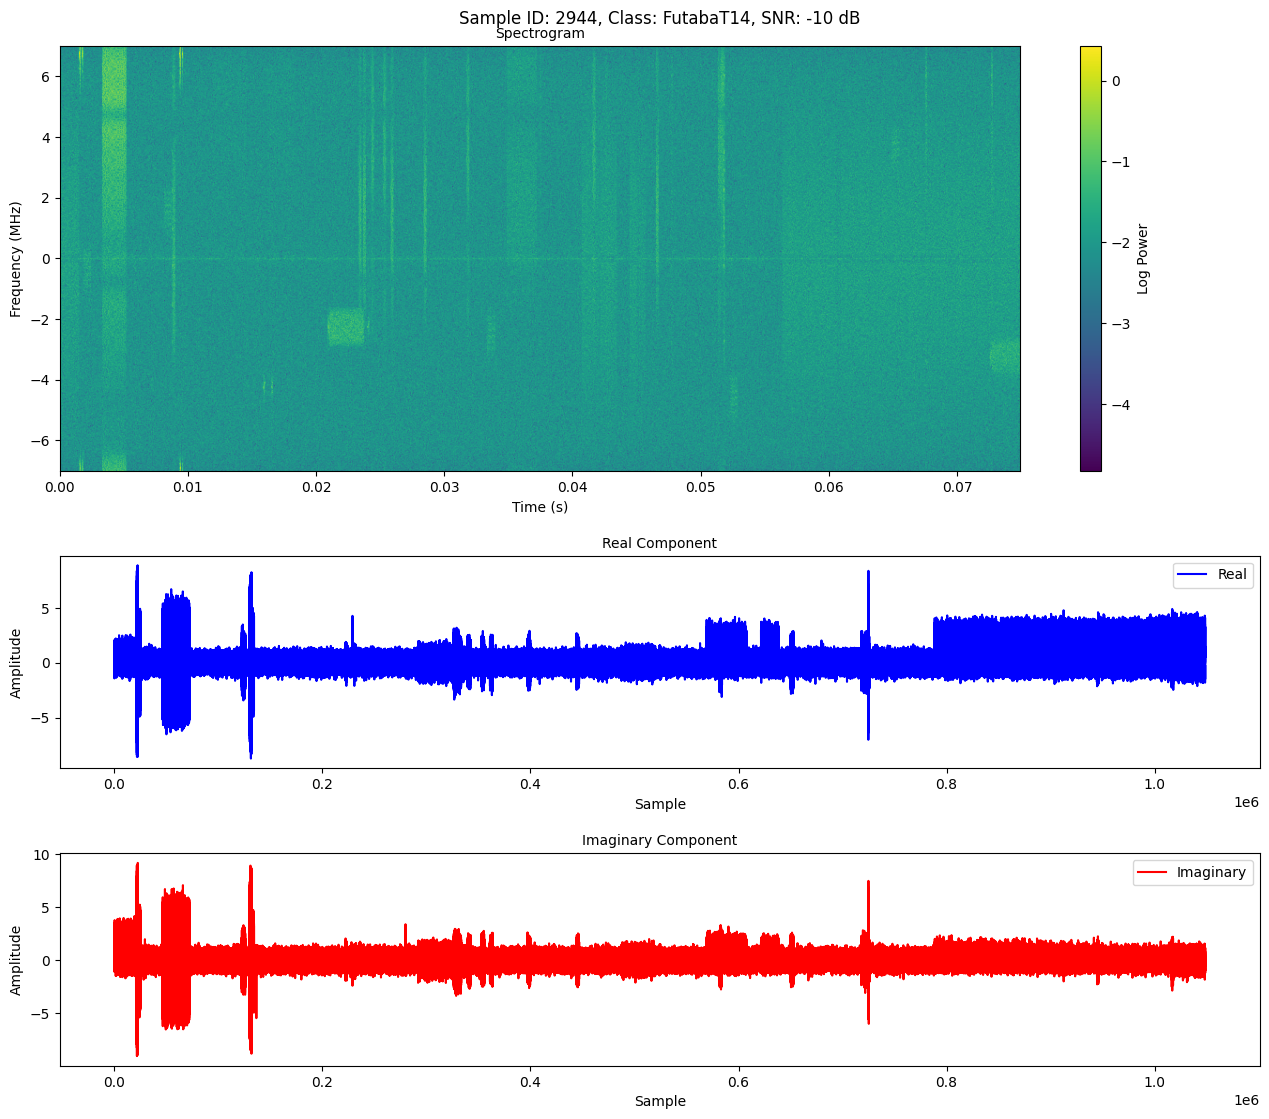

Completed plotting and saving for FutabaT14

Plotting and saving for class: FutabaT7
Plot saved as: ./plots/FutabaT7_combined_plot.png


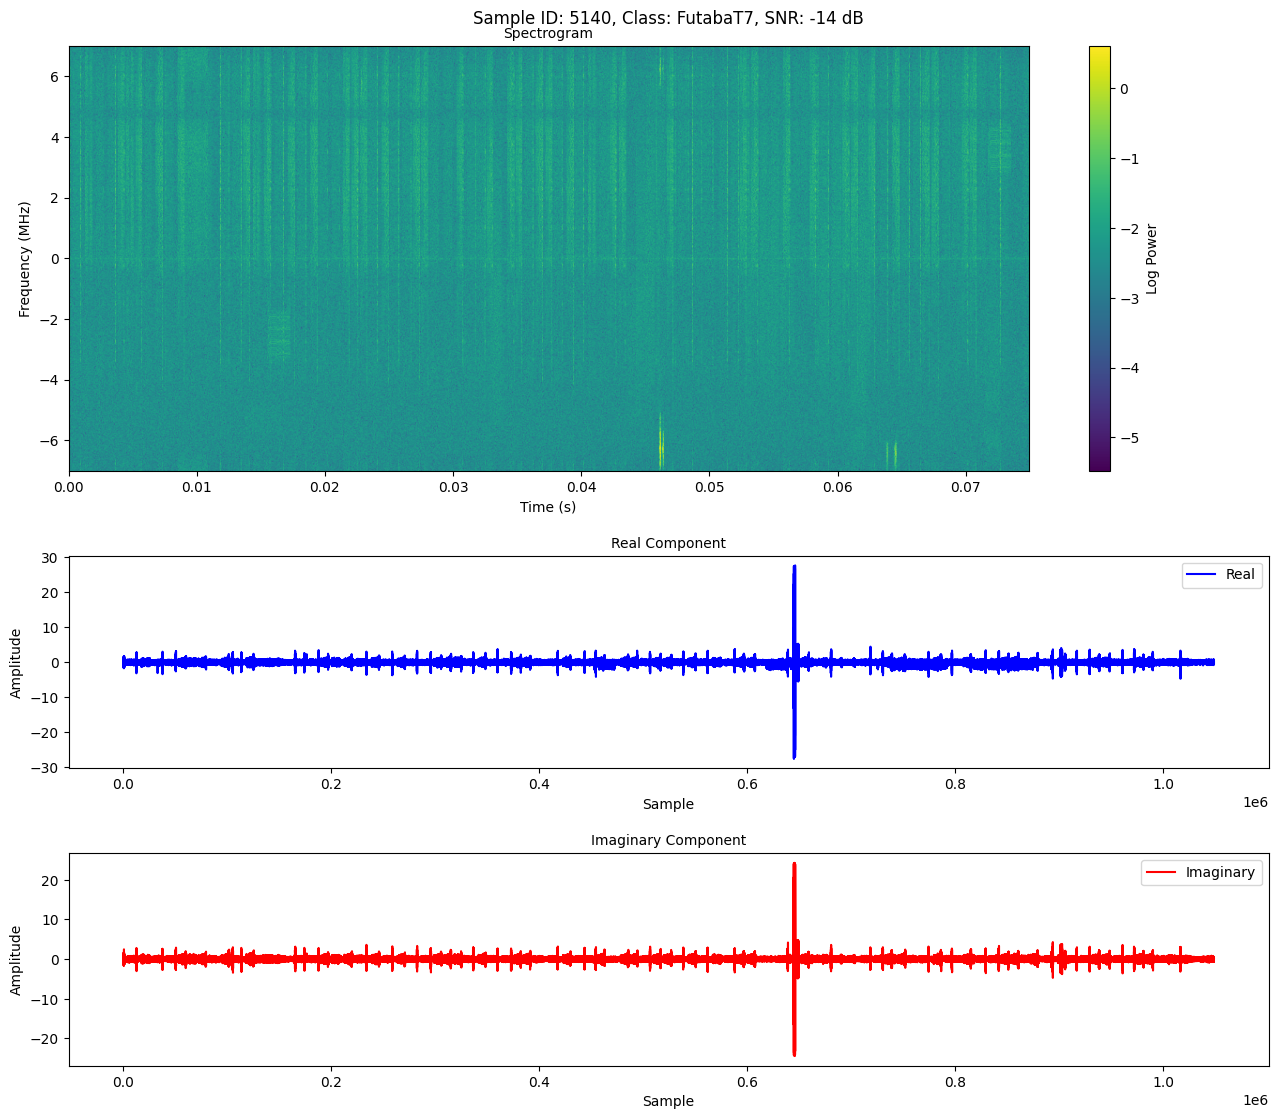

Completed plotting and saving for FutabaT7

Plotting and saving for class: Graupner
Plot saved as: ./plots/Graupner_combined_plot.png


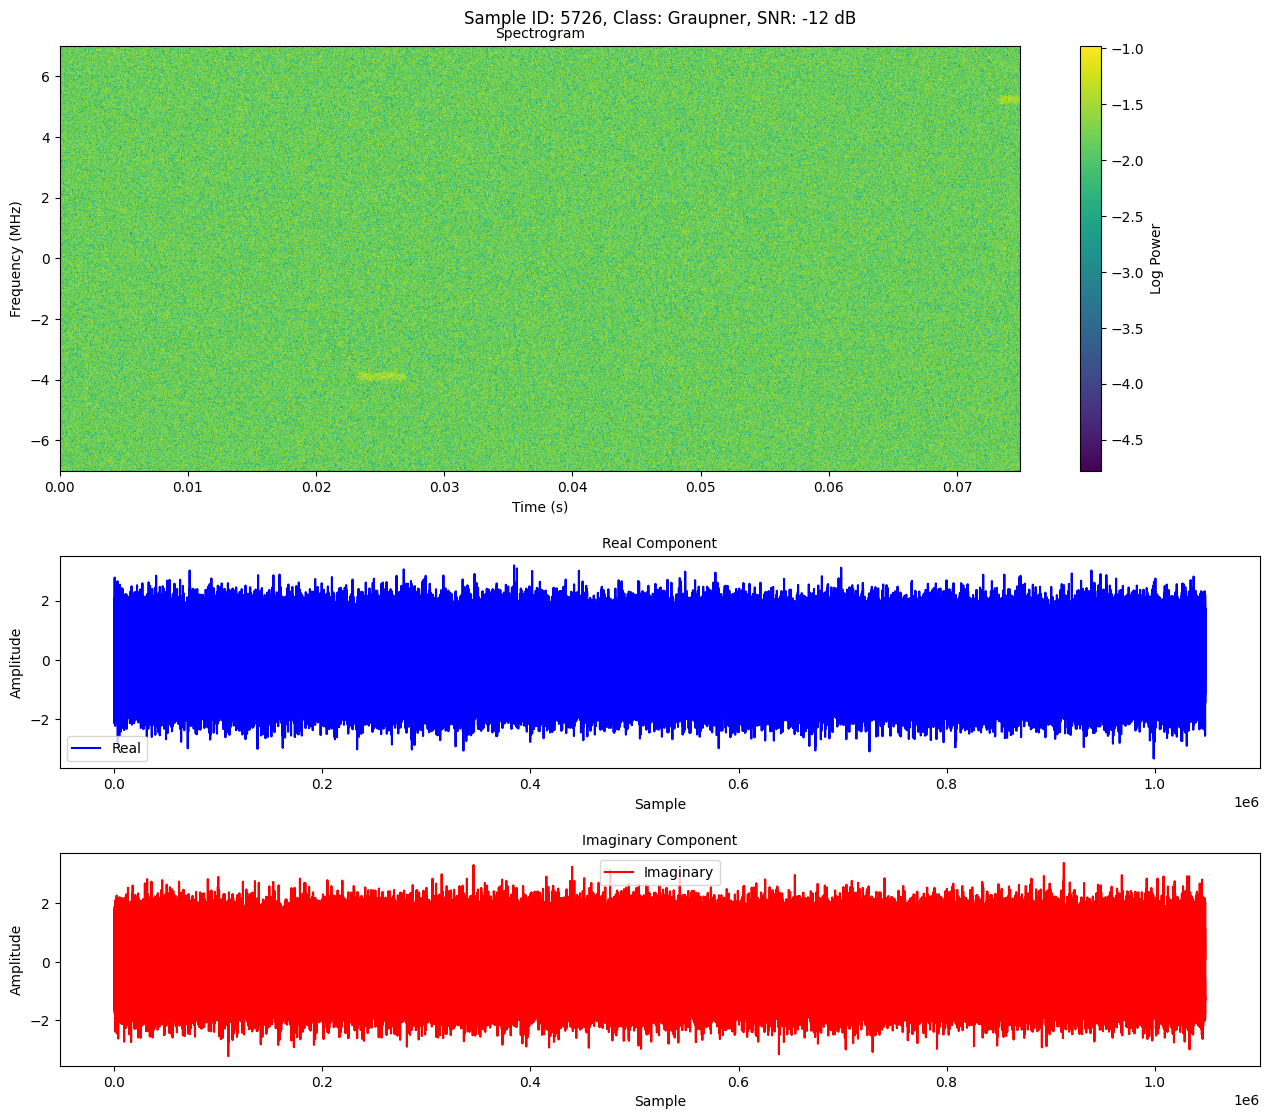

Completed plotting and saving for Graupner

Plotting and saving for class: Noise
Plot saved as: ./plots/Noise_combined_plot.png


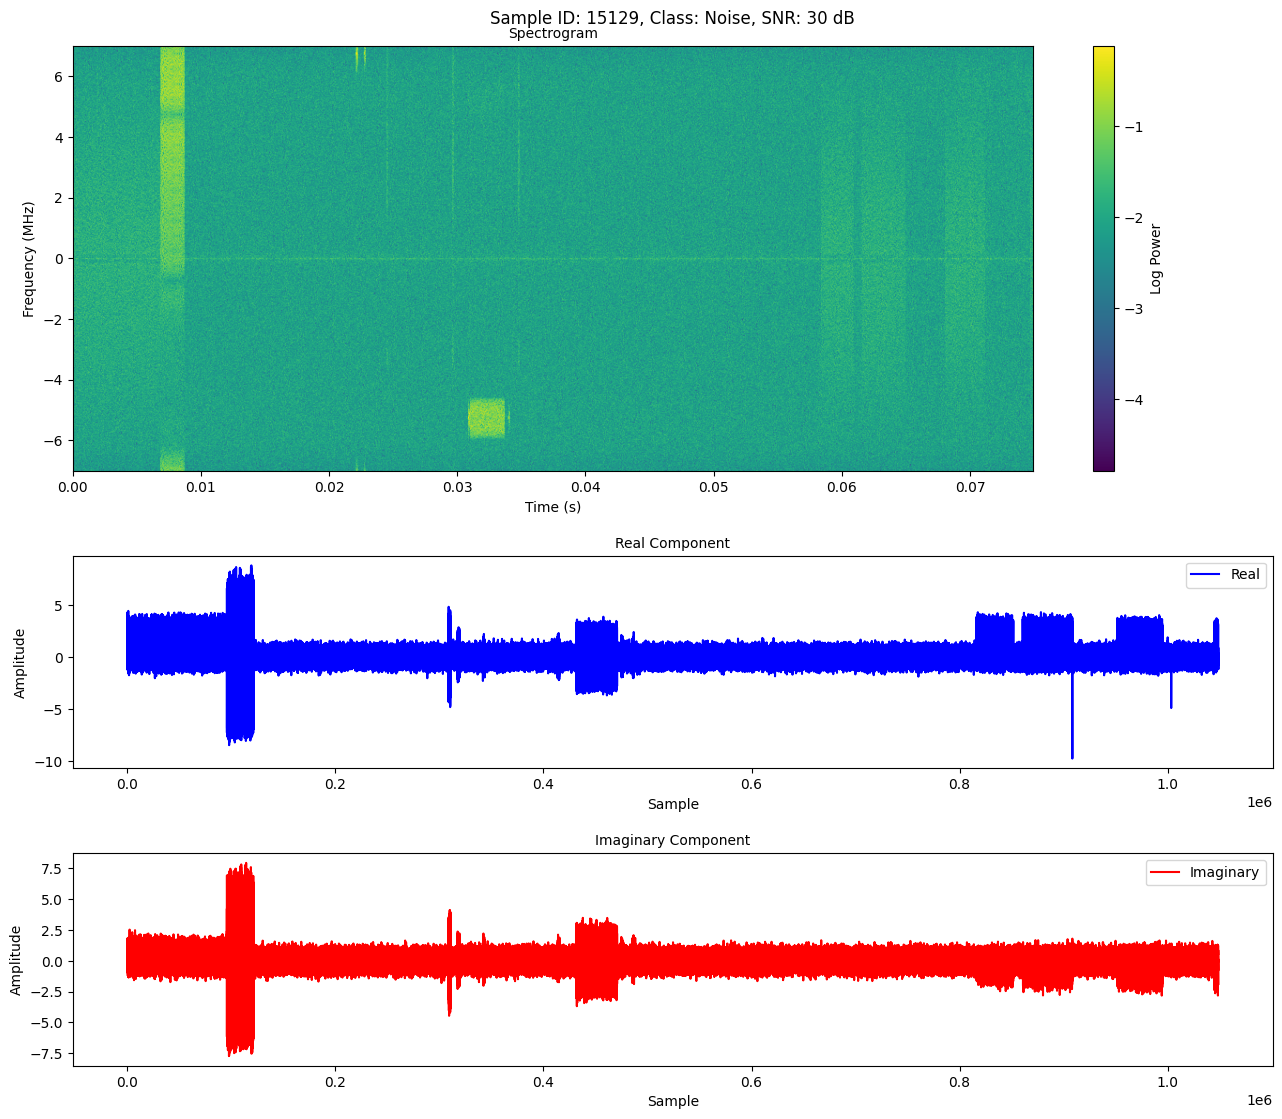

Completed plotting and saving for Noise

Plotting and saving for class: Taranis
Plot saved as: ./plots/Taranis_combined_plot.png


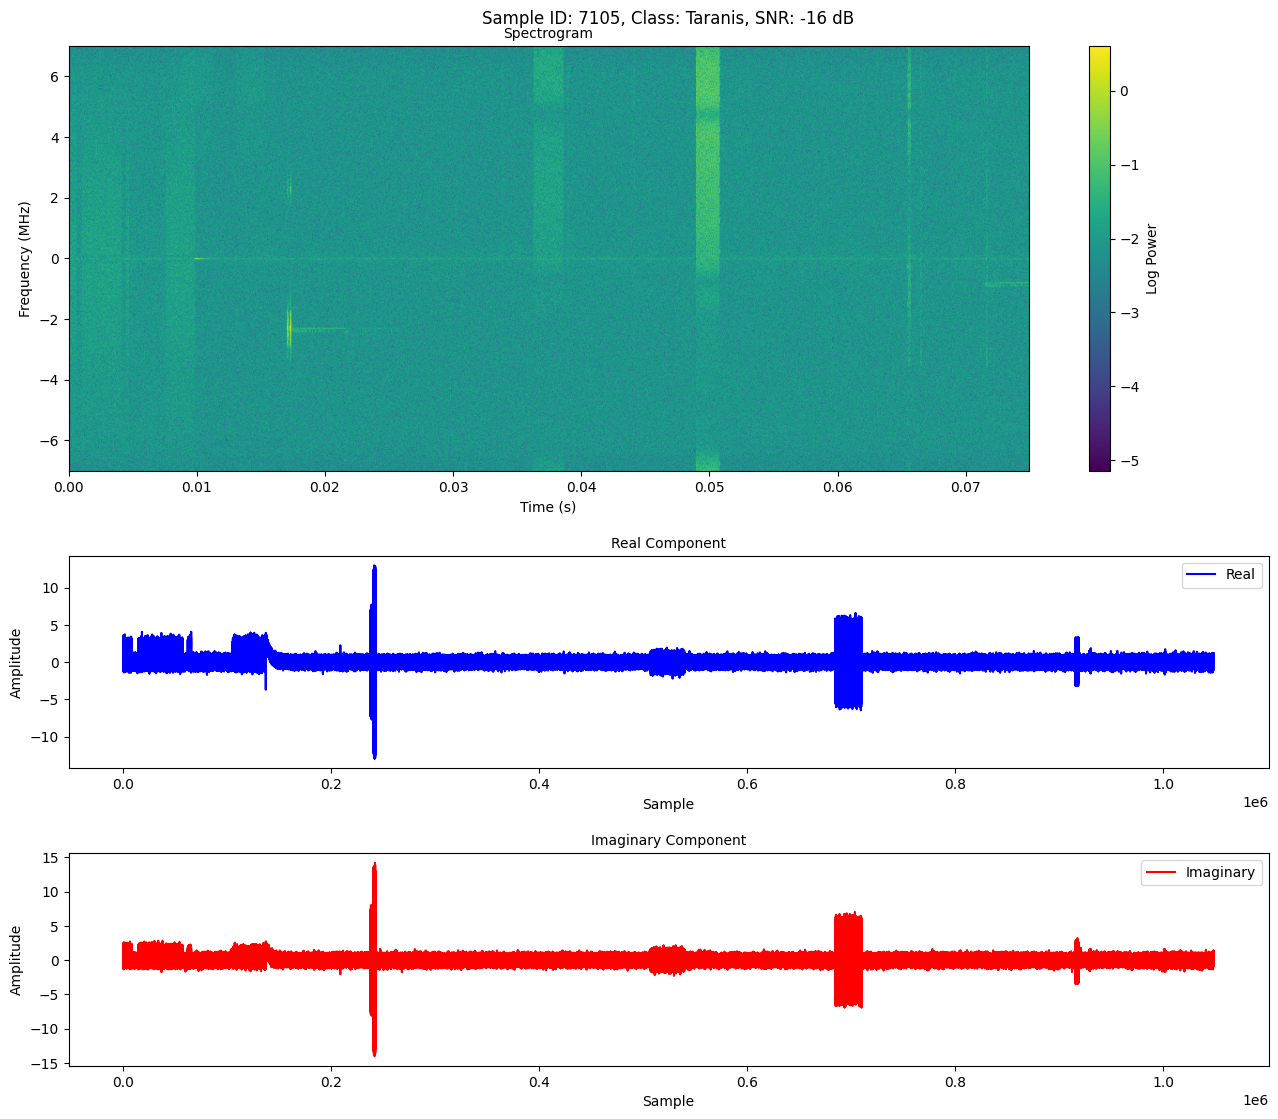

Completed plotting and saving for Taranis

Plotting and saving for class: Turnigy
Plot saved as: ./plots/Turnigy_combined_plot.png


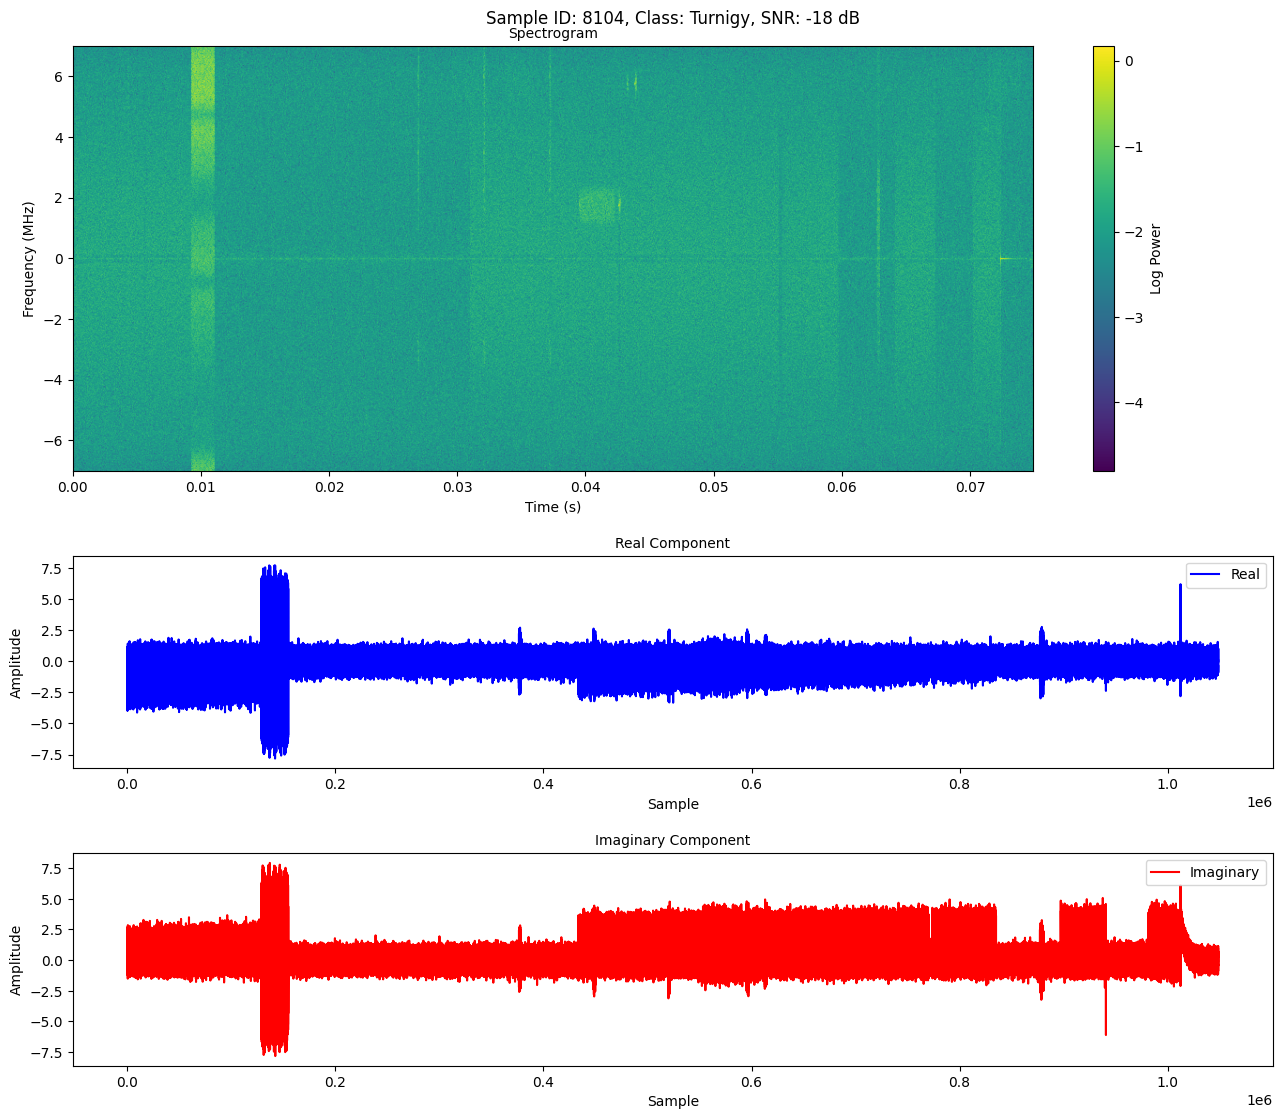

Completed plotting and saving for Turnigy



In [1]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchaudio.transforms import Spectrogram
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


class drone_data_dataset(Dataset):
    """
    Dataset class for drone IQ Signals + transform to spectrogram
    """
    def __init__(self, path, transform=None, device=None):
        self.path = path
        self.files = os.listdir(path)
        self.files = [f for f in self.files if f.endswith('pt')] # filter for files with .pt extension  
        self.files = [f for f in self.files if f.startswith('IQdata_sample')] # filter for files which start with IQdata_sample in name
        self.transform = transform
        self.device = device

        # create list of tragets and snrs for all samples
        self.targets = []
        self.snrs = []
        
        for file in self.files:
            self.targets.append(int(file.split('_')[2][6:])) # get target from file name
            self.snrs.append(int(file.split('_')[3].split('.')[0][3:])) # get snr from file name

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        sample_id = int(file.split('_')[1][6:]) # get sample id from file name
        data_dict = torch.load(self.path + file) # load data       
        iq_data = data_dict['x_iq']
        act_target = data_dict['y']
        act_snr = data_dict['snr']

        if self.transform:
            if self.device:
                iq_data = iq_data.to(device=device)
            transformed_data = self.transform(iq_data)
        else:
            transformed_data = None

        return iq_data, act_target, act_snr, sample_id, transformed_data
    
    def get_targets(self): # return list of targets
        return self.targets

    def get_snrs(self): # return list of snrs
        return self.snrs
    
    def get_files(self):
        return self.files


class transform_spectrogram(torch.nn.Module):
    def __init__(
        self,
        device,
        n_fft=1024,
        win_length=1024,
        hop_length=1024,
        window_fn=torch.hann_window,
        power=None, # Exponent for the magnitude spectrogram, (must be > 0) e.g., 1 for magnitude, 2 for power, etc. If None, then the complex spectrum is returned instead. (Default: 2)
        normalized=False,
        center=False,
        #pad_mode='reflect',
        onesided=False
    ):
        super().__init__()
        self.spec = Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, window_fn=window_fn, power=power, normalized=normalized, center=center, onesided=onesided).to(device=device)   
        self.win_lengt = win_length

    def forward(self, iq_signal: torch.Tensor) -> torch.Tensor:
        # Convert to spectrogram
        iq_signal = iq_signal[0,:] + (1j * iq_signal[1,:]) # convert to complex signal
        spec = self.spec(iq_signal)
        spec = torch.view_as_real(spec) # Returns a view of a complex input as a real tensor. last dimension of size 2 represents the real and imaginary components of complex numbers
        spec = torch.moveaxis(spec,2,0) # move channel dimension to first dimension (1024, 1024, 2) -> (2, 1024, 1024)
        spec = spec/self.win_lengt # normalise by fft window size
        return spec


def plot_combined_iq_and_spectrum(iq_2d, spectrogram_2d, title='', save_path=None, n_fft=1024, sampling_rate=14e6):
    fig = plt.figure(figsize=(15, 12))
    
    # Create gridspec with 3 rows and 1 column
    # First row (spectrogram) gets twice the height of other rows
    # Reduce top margin with top parameter
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.3, top=0.95)
    
    # Plot Spectrogram (top, full width, increased height)
    ax1 = fig.add_subplot(gs[0])
    # FFT-shift such that freq axis is in [-7, 7]MHz instead of [0, 14] MHz
    spectrogram_2d = np.roll(spectrogram_2d, n_fft//2, axis=1)
    power = np.log10(np.sqrt(spectrogram_2d[0,:,:]**2 + spectrogram_2d[1,:,:]**2))
    hop_length = n_fft
    num_frames = spectrogram_2d.shape[2]
    total_time = num_frames * (hop_length / sampling_rate)
    freq_range = sampling_rate / 2

    im = ax1.imshow(power, extent=[0, total_time, -freq_range/1e6, freq_range/1e6], aspect='auto')
    plt.colorbar(im, ax=ax1, label='Log Power')
    ax1.set_title('Spectrogram', fontsize=10)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (MHz)")

    # Plot Real Channel (middle row)
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(iq_2d[0,:], 'b', label='Real')
    ax2.set_title('Real Component', fontsize=10)
    ax2.set_xlabel("Sample")
    ax2.set_ylabel("Amplitude")
    ax2.legend()

    # Plot Imaginary Channel (bottom row)
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(iq_2d[1,:], 'r', label='Imaginary')
    ax3.set_title('Imaginary Component', fontsize=10)
    ax3.set_xlabel("Sample")
    ax3.set_ylabel("Amplitude")
    ax3.legend()

    # Set overall title closer to the plot
    fig.suptitle(title, fontsize=12, y=0.98)
    
    # Don't use tight_layout as it can override our specific spacing settings
    # Instead, adjust the subplot parameters directly
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.95)

    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved as: {save_path}")

    plt.show()

# Main Execution (updated part remains largely the same)
if __name__ == "__main__":
    project_path = './'
    data_path = '/kaggle/input/noisy-drone-rf-signal-classification-v2/drone_RF_data/'

    # Read class statistics
    dataset_stats = pd.read_csv(data_path + 'class_stats.csv', index_col=0)
    class_names = dataset_stats['class'].values

    # Set device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Setup transform: IQ -> SPEC
    data_transform = transform_spectrogram(device=device)

    # Create dataset object
    drone_dataset = drone_data_dataset(path=data_path, device=device, transform=data_transform)

    # Get all targets and files
    all_targets = drone_dataset.get_targets()
    all_files = drone_dataset.get_files()

    # Find one sample for each class
    unique_classes = set(all_targets)
    samples_per_class = {i: [] for i in unique_classes}

    # Map class indices to names
    class_idx_to_name = {i: name for i, name in enumerate(class_names)}

    # Populate samples per class
    for idx, target in enumerate(all_targets):
        samples_per_class[target].append(idx)

    # Plot and save for each class
    output_dir = './plots/'
    os.makedirs(output_dir, exist_ok=True)

    for class_idx in sorted(unique_classes):
        if samples_per_class[class_idx]:  # Ensure there are samples for this class
            sample_idx = samples_per_class[class_idx][0]  # Take the first sample of this class

            # Load the sample
            iq_data, target, snr, sample_id, transformed_data = drone_dataset[sample_idx]

            # Convert to CPU and numpy for plotting
            iq_data_np = iq_data.cpu().numpy()
            transformed_data_np = transformed_data.cpu().numpy()

            # Create title and save path
            class_name = class_idx_to_name[class_idx]
            plot_title = f'Sample ID: {sample_id}, Class: {class_name}, SNR: {snr.item()} dB'
            save_file = os.path.join(output_dir, f'{class_name}_combined_plot.png')

            # Plot combined
            print(f"Plotting and saving for class: {class_name}")
            plot_combined_iq_and_spectrum(iq_data_np, transformed_data_np, title=plot_title, save_path=save_file)

            print(f"Completed plotting and saving for {class_name}\n")


In [2]:

# Data for all models
models = ['SqueezeNet', 'ShuffleNet', 'MobileNetV2', 'EfficientNet', 'DenseNet-121', 
          'ResNet-50', 'ResNeXt-50', 'Inception-v3', 'Wide ResNet-50']

# Metrics (normalized to 0-1 scale)
metrics = {
    'Accuracy': [0.944, 0.925, 0.950, 0.938, 0.957, 0.954, 0.957, 0.952, 0.957],
    'Parameters': [0.726, 1.26, 2.23, 4.02, 6.96, 23.52, 22.99, 24.36, 66.85],
    'FLOPs': [0.263, 0.152, 0.326, 0.414, 2.90, 4.13, 4.29, 5.75, 11.45],
    'Inference_Time': [2.244, 6.554, 5.223, 8.263, 16.616, 5.656, 7.946, 11.958, 7.828],
    'Training_Time': [1.08, 0.70, 0.63, 0.50, 1.12, 0.85, 0.64, 1.05, 1.28]
}

# Normalize metrics
scaler = MinMaxScaler()
for key in metrics:
    if key != 'Accuracy':  # Don't normalize accuracy
        metrics[key] = 1 - scaler.fit_transform(np.array(metrics[key]).reshape(-1, 1)).flatten()
    else:
        metrics[key] = scaler.fit_transform(np.array(metrics[key]).reshape(-1, 1)).flatten()

# Calculate overall score (weighted average)
weights = {'Accuracy': 0.4, 'Parameters': 0.15, 'FLOPs': 0.15, 
           'Inference_Time': 0.15, 'Training_Time': 0.15}

overall_scores = np.zeros(len(models))
for key, weight in weights.items():
    overall_scores += metrics[key] * weight

# Create radar plot
categories = list(weights.keys())
num_vars = len(categories)

angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

# Plot
plt.figure(figsize=(15, 10))

# Plot for each model
for i, model in enumerate(models):
    values = [metrics[key][i] for key in categories]
    values += values[:1]
    
    ax = plt.subplot(3, 3, i+1, polar=True)
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(f"{model}\nOverall Score: {overall_scores[i]:.3f}")

plt.tight_layout()
plt.savefig('model_comparison_radar.png', dpi=300, bbox_inches='tight')
plt.close()

# Create bar plot of overall scores
plt.figure(figsize=(12, 6))
plt.bar(models, overall_scores)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Overall Performance Score')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.savefig('model_comparison_bar.png', dpi=300, bbox_inches='tight')
plt.close()